Alzheimers Disease Dataset. Available at: https://www.kaggle.com/datasets/kumarln/alzheimers-disease-dataset (Accessed: .5 April 2023)

In [1]:
import torch
torch.cuda.is_available()

True

In [2]:
!pip install torchsummary

Defaulting to user installation because normal site-packages is not writeable


In [3]:
torch.cuda.empty_cache()

In [4]:
%matplotlib inline
import numpy as np
import pandas as pd
import seaborn as sns
import os
import time
import random 
import shutil
from skimage import io, transform
import math
import pandas as pd
import torchvision
from torchvision.datasets import ImageFolder
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, utils
from torchvision import datasets, transforms
import torch.nn.functional as F
from torchvision.utils import make_grid

import torch.optim as optim

import torch.nn as nn
from PIL import Image
import matplotlib.pyplot as plt
import cv2
import warnings

from tqdm.auto import tqdm

from torchsummary import summary

import requests
from pathlib import Path 
warnings.filterwarnings("ignore")

plt.ion()   # interactive mode

print("using Pytorch version", torch.__version__)

using Pytorch version 1.13.1


LOAD DATASET

In [6]:
torch.manual_seed(42)
# File paths
# data_dir = "/kaggle/input/augmented-alzheimer-mri-dataset-v2/data"

# train_folder = os.path.join(data_dir + "/train")
# test_folder = os.path.join(data_dir + "/val")

# # Get class names
# class_names = os.listdir(train_folder)
# print(class_names)


data_dir = "C:/Users/DELL G7/Pictures/deepL/aug_mri_scan"

train_folder = os.path.join(data_dir + "/train")
test_folder = os.path.join(data_dir + "/test")

# Get class names
class_names = os.listdir(train_folder)
print(class_names)

['MildDemented', 'ModerateDemented', 'NonDemented', 'VeryMildDemented']


VISUALIZE THE DATASET

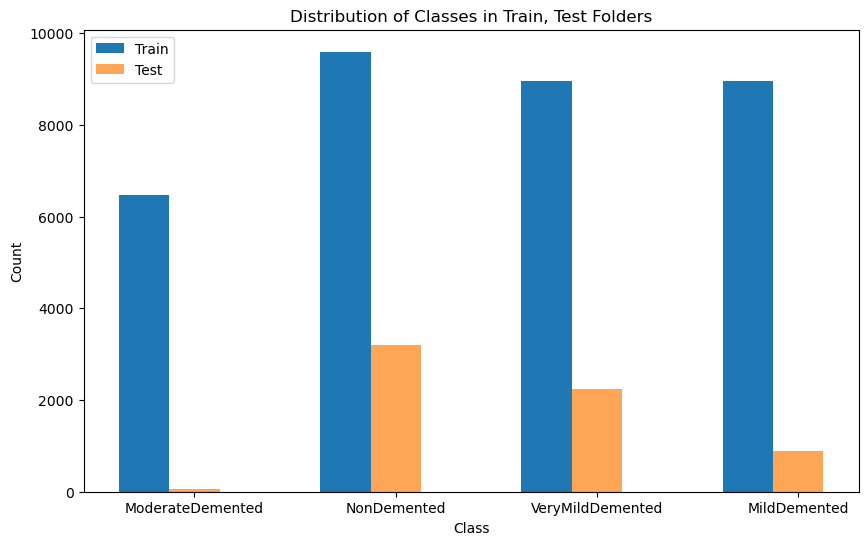

In [8]:


# Count number of samples in train and test folders for each class
train_counts = []
test_counts = []

for class_name in class_names:
    train_path = os.path.join(train_folder, class_name)
    test_path = os.path.join(test_folder, class_name)
    train_count = len(os.listdir(train_path))
    test_count = len(os.listdir(test_path))
    train_counts.append(train_count)
    test_counts.append(test_count)


# Create positions for the bars
bar_width = 0.25
x_train = np.arange(len(class_names))
x_test = x_train + bar_width

# Plotting the chart
fig, ax = plt.subplots(figsize=(10, 6))
ax.bar(x_train, train_counts, width=bar_width, label='Train')
ax.bar(x_test, test_counts, width=bar_width, label='Test', alpha=0.7)
ax.set_xlabel('Class')
ax.set_ylabel('Count')
ax.set_xticks(x_train + bar_width)
ax.set_xticklabels(class_names)
ax.set_xticklabels(class_names)
ax.set_title('Distribution of Classes in Train, Test Folders')
ax.legend()
plt.show()

CHECK SHAPE OF TEST AND TRAIN DATA

In [7]:


# Print size of 5 random TRAIN images

transform = transforms.Compose([transforms.ToTensor()])

train_dataset = datasets.ImageFolder(train_folder, transform=transform)

train_list = [(img, label) for img, label in train_dataset]


for img, _ in random.sample(train_list, k=5):
    print(img.size())


torch.Size([3, 190, 200])
torch.Size([3, 180, 180])
torch.Size([3, 180, 180])
torch.Size([3, 190, 200])
torch.Size([3, 190, 200])


In [8]:
# Print size of 5 random TEST images

test_dataset = datasets.ImageFolder(test_folder, transform=transform)

# Convert dataset to a list of tuples
test_list = [(img, label) for img, label in test_dataset]


for img, _ in random.sample(test_list, k=5):
    print(img.size())

torch.Size([3, 208, 176])
torch.Size([3, 208, 176])
torch.Size([3, 208, 176])
torch.Size([3, 208, 176])
torch.Size([3, 208, 176])


CALCULATE MEAN OF DATASET TO BE USED IN TRANSFORMS

In [9]:
# Calculate the mean and std of the train dataset to be used in normalization
# because of the size of dataset, a subset of 10000 will be used
torch.manual_seed(42)
np.random.seed(42)

# Define the transformation for normalization
transform = transforms.Compose([
    transforms.Resize((224, 224)),  # resize to a fixed size
    transforms.ToTensor(),
])

# Load the dataset
train_dataset = datasets.ImageFolder(train_folder, transform=transform)

# Calculate the mean and standard deviation for a subset of the dataset
subset_indices = np.random.choice(len(train_dataset), size=10000, replace=False)
subset_sampler = torch.utils.data.sampler.SubsetRandomSampler(subset_indices)
subset_loader = torch.utils.data.DataLoader(train_dataset, sampler=subset_sampler, batch_size=1)

data = torch.zeros(3, 224, 224)
for img, _ in subset_loader:
    data += img[0]
train_mean = data.mean(dim=[1, 2]) / len(subset_loader)
train_std = data.std(dim=[1, 2]) / len(subset_loader)

print('Train Mean:', train_mean)
print('Train Std:', train_std)

Train Mean: tensor([0.2951, 0.2948, 0.2950])
Train Std: tensor([0.2612, 0.2611, 0.2611])


APPLY TRANSFORMS TO DATASET TO RESIZE THE IMAGE AND APPLYING THE CALCULATED MEAN AND STD

In [10]:

# Define transforms for data preprocessing
train_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.RandomRotation(60),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize(train_mean, train_std)
])



# Define transforms for data preprocessing
test_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(train_mean, train_std)
])
# Load the image folder
train_folder_new = ImageFolder(train_folder, transform=train_transform)
test_folder_new = ImageFolder(test_folder, transform=test_transform)

CHECK PROPERTIES OF DATASET

In [11]:
# How many samples are there? 
len_train = len(train_folder_new)
len_test = len(test_folder_new)

print(f" Num of Train dataset is " + str(len_train))

print(f" Num of Test dataset is " + str(len_test))


 Num of Train dataset is 33984
 Num of Test dataset is 6400


In [12]:
# Create a DataLoader with the  TRAIN dataset and the TEST data
size_of_workers= 2
size_of_batch = 32
train_loader = DataLoader(train_folder_new, batch_size=size_of_batch, shuffle=True,  num_workers=size_of_workers)
test_loader = DataLoader(test_folder_new, batch_size=size_of_batch,shuffle=False,  num_workers=size_of_workers)

In [13]:
# Let's check out what we've created
print(f"Dataloaders: {train_loader, test_loader}") 
print(f"Length of train dataloader: {len(train_loader)} batches of {size_of_batch}")
print(f"Length of test dataloader: {len(test_loader)} batches of {size_of_batch}")

Dataloaders: (<torch.utils.data.dataloader.DataLoader object at 0x000001FDD891C370>, <torch.utils.data.dataloader.DataLoader object at 0x000001FDD891C280>)
Length of train dataloader: 1062 batches of 32
Length of test dataloader: 200 batches of 32


In [14]:

def show_batch(dl):
    for images, labels in dl:
        fig, ax = plt.subplots(figsize=(12, 6))
        ax.set_xticks([]); ax.set_yticks([])
        ax.imshow(make_grid(images, nrow=8).permute(1, 2, 0))
        break

In [15]:
# Check out what's inside the training dataloader
train_features_batch, train_labels_batch = next(iter(train_loader))
train_features_batch.shape, train_labels_batch.shape

(torch.Size([32, 3, 224, 224]), torch.Size([32]))

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


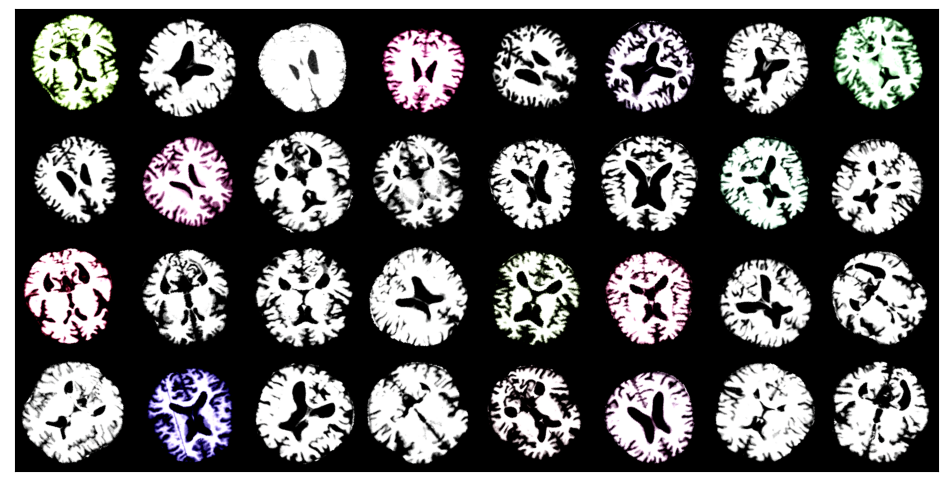

In [16]:
show_batch(train_loader)

In [17]:
# Check out what's inside the test dataloader
test_features_batch, test_labels_batch = next(iter(test_loader))
test_features_batch.shape, test_labels_batch.shape

(torch.Size([32, 3, 224, 224]), torch.Size([32]))

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


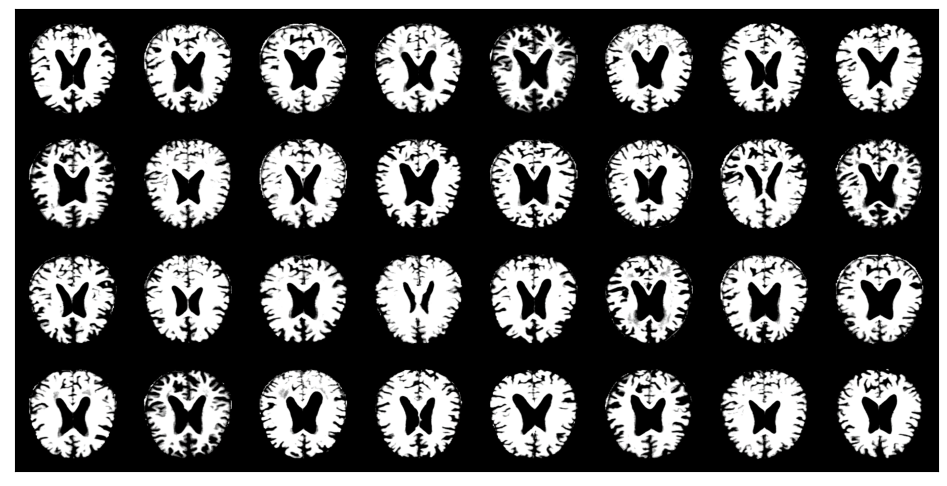

In [18]:
show_batch(test_loader)

In [20]:
# Download helper functions from Learn PyTorch repo (if not already downloaded)
if Path("helper_functions.py").is_file():
  print("helper_functions.py already exists, skipping download")
else:
  print("Downloading helper_functions.py")
  # Note: you need the "raw" GitHub URL for this to work
  request = requests.get("https://raw.githubusercontent.com/mrdbourke/pytorch-deep-learning/main/helper_functions.py")
  with open("helper_functions.py", "wb") as f:
    f.write(request.content)

SET UP DEVICE

In [21]:
# Setup device agnostic code
torch.manual_seed(42)
np.random.seed(42)
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cuda'

DEFINE ACCURACY FUNCTION

In [22]:
# Import accuracy metric
from helper_functions import accuracy_fn

# Calculate accuracy (a classification metric)
def accuracy_fn(y_true, y_pred):
    """Calculates accuracy between truth labels and predictions.

    Args:
        y_true (torch.Tensor): Truth labels for predictions.
        y_pred (torch.Tensor): Predictions to be compared to predictions.

    Returns:
        [torch.float]: Accuracy value between y_true and y_pred, e.g. 78.45
    """
    correct = torch.eq(y_true, y_pred).sum().item()
    acc = (correct / len(y_pred)) #remove 100
    return acc

DEFINE TIMER FUNCTION

In [23]:
from timeit import default_timer as timer 
def print_train_time(start: float, end: float, device: torch.device):
    """Prints difference between start and end time.

    Args:
        start (float): Start time of computation (preferred in timeit format). 
        end (float): End time of computation.
        device ([type], optional): Device that compute is running on. Defaults to None.

    Returns:
        float: time between start and end in seconds (higher is longer).
    """
    total_time = end - start
    print(f"Train time on {device}: {total_time:.3f} seconds")
    return total_time

DEFINE TRAINING FUNCTION

In [24]:
torch.manual_seed(42)
np.random.seed(42)
def train_step(model: torch.nn.Module,
               data_loader: torch.utils.data.DataLoader,
               loss_fn: torch.nn.Module,
               optimizer: torch.optim.Optimizer,
               accuracy_fn,
               # scheduler: torch.optim.lr_scheduler._LRScheduler,
               device: torch.device = device):
            
    
    
    train_loss, train_acc = 0, 0
    model.to(device)
    for batch, (X, y) in enumerate(data_loader):
        # Send data to GPU
        X, y = X.to(device), y.to(device)

        # 1. Forward pass
        y_pred = model(X)

        # 2. Calculate loss
        loss = loss_fn(y_pred, y)
        train_loss += loss
        train_acc += accuracy_fn(y_true=y,
                                 y_pred=y_pred.argmax(dim=1)) # Go from logits -> pred labels

        # 3. Optimizer zero grad
        optimizer.zero_grad()

        # 4. Loss backward
        loss.backward()

        # 5. Optimizer step
        optimizer.step()
        
            # Update the learning rate
        # scheduler.step()

    # Calculate loss and accuracy per epoch and print out what's happening
    train_loss /= len(data_loader)
    train_acc /= len(data_loader)
   
    print(f"Train loss: {train_loss:.3f} | Train accuracy: {train_acc:.3f}")
   
    
    return train_loss, train_acc
     

DEFINE TESTING FUNCTION

In [25]:
torch.manual_seed(42)
np.random.seed(42)

def test_step(data_loader: torch.utils.data.DataLoader,
              model: torch.nn.Module,
              loss_fn: torch.nn.Module,
              accuracy_fn,
              device: torch.device = device):
        
    
    
    test_loss, test_acc = 0, 0
    model.to(device)
    model.eval() # put model in eval mode
    # Turn on inference context manager
    with torch.inference_mode(): 
        for X, y in data_loader:
            # Send data to GPU
            X, y = X.to(device), y.to(device)
            
            # 1. Forward pass
            test_pred = model(X)
            
            # 2. Calculate loss and accuracy
            test_loss += loss_fn(test_pred, y)
            test_acc += accuracy_fn(y_true=y,
            y_pred=test_pred.argmax(dim=1)) # Go from logits -> pred labels
        
        # Adjust metrics and print out
        test_loss /= len(data_loader)
        test_acc /= len(data_loader)
      
#         print(f"Learning rate: {scheduler.get_last_lr()[0]:.6f}")
        print(f"Test loss: {test_loss:.3f} | Test accuracy: {test_acc:.3f}%\n")

        return test_loss, test_acc

DEFINE EVALUATION FUNCTION

In [26]:
        
def eval_model(model: torch.nn.Module, 
               data_loader: torch.utils.data.DataLoader, 
               loss_fn: torch.nn.Module, 
               accuracy_fn, 
               device: torch.device = device):
    """Evaluates a given model on a given dataset.

    Args:
        model (torch.nn.Module): A PyTorch model capable of making predictions on data_loader.
        data_loader (torch.utils.data.DataLoader): The target dataset to predict on.
        loss_fn (torch.nn.Module): The loss function of model.
        accuracy_fn: An accuracy function to compare the models predictions to the truth labels.
        device (str, optional): Target device to compute on. Defaults to device.

    Returns:
        (dict): Results of model making predictions on data_loader.
    """
    loss, acc = 0, 0
    model.eval()
    with torch.inference_mode():
        for X, y in data_loader:
            # Send data to the target device
            X, y = X.to(device), y.to(device)
            y_pred = model(X)
            loss += loss_fn(y_pred, y)
            acc += accuracy_fn(y_true=y, y_pred=y_pred.argmax(dim=1))
        
        # Scale loss and acc
        loss /= len(data_loader)
        acc /= len(data_loader)
    return {"model_name": model.__class__.__name__, # only works when model was created with a class
            "model_loss": loss.item(),
            "model_acc": acc}


DEFINE PREDICTION FUNCTION

In [27]:
def make_predictions(model: torch.nn.Module, data: list, device: torch.device = device):
    pred_probs = []
    model.eval()
    with torch.inference_mode():
        for sample in data:
            # Prepare sample
            sample = torch.unsqueeze(sample, dim=0).to(device) # Add an extra dimension and send sample to device

            # Forward pass (model outputs raw logit)
            pred_logit = model(sample)

            # Get prediction probability (logit -> prediction probability)
            pred_prob = torch.softmax(pred_logit.squeeze(), dim=0)

            # Get pred_prob off GPU for further calculations
            pred_probs.append(pred_prob.cpu())
            
    # Stack the pred_probs to turn list into a tensor
    return torch.stack(pred_probs)

DEFINING RANDOM LIST FOR PREDICTION

In [28]:
torch.manual_seed(42)
np.random.seed(42)

from sklearn.model_selection import StratifiedShuffleSplit
from collections import Counter

# Create a StratifiedShuffleSplit object
sss = StratifiedShuffleSplit(n_splits=1, test_size=0.5, random_state=42)

# Get the class labels from the test dataset
class_labels = test_folder_new.targets

# Split the test set
test_idx, _ = next(sss.split(test_folder_new, class_labels))

# Get the test samples and labels based on the split indices
test_samples = [test_folder_new[i][0] for i in test_idx]
test_labels = [test_folder_new[i][1] for i in test_idx]

# Calculate the class distribution in the test samples
class_distribution = Counter(test_labels)

# Print the class distribution
for label, count in class_distribution.items():
    class_name = test_folder_new.classes[label]
    print(f"Class {label}: {class_name}, Count: {count}")

# View the first test sample shape and label
print(f"Test sample image shape: {test_samples[0].shape}\nTest sample label: {test_labels[0]} ({class_names[test_labels[0]]})")

Class 0: MildDemented, Count: 448
Class 2: NonDemented, Count: 1600
Class 3: VeryMildDemented, Count: 1120
Class 1: ModerateDemented, Count: 32
Test sample image shape: torch.Size([3, 224, 224])
Test sample label: 0 (MildDemented)


BUILD A CNN MODEL NAMED ALZHEIMERNETV2

In [29]:
from torch.nn.modules import MaxPool2d
# Create a convolutional neural network 
class AlzheimerDetection(nn.Module):
    """
    Model architecture copying TinyVGG from: 
    https://poloclub.github.io/cnn-explainer/
    """
    def __init__(self, input_shape: int, hidden_units: int, output_shape: int):
        super().__init__()

        # LAYER ONE
        self.conv_block_1 = nn.Sequential(
            nn.Conv2d(in_channels=input_shape, 
                      out_channels=hidden_units, 
                      kernel_size=3, # how big is the square that's going over the image?
                      stride=1, # default
                      padding=1),# options = "valid" (no padding) or "same" (output has same shape as input) or int for specific number 
            nn.ReLU(),
            nn.Dropout(0.25),

            nn.Conv2d(in_channels=hidden_units,
                      out_channels=hidden_units,
                      kernel_size=3,
                      stride=1,
                      padding=1),
            nn.ReLU(),
            nn.Dropout(0.25),
            nn.MaxPool2d(kernel_size=2)
        )
        
        #LAYER TWO
        self.conv_block_2 = nn.Sequential(
            nn.Conv2d(in_channels=hidden_units,
                      out_channels=hidden_units,
                      kernel_size=3,
                      stride=1,
                      padding=1),
            nn.ReLU(),
            nn.Dropout(0.25),

            
            nn.Conv2d(in_channels=hidden_units,
                      out_channels=hidden_units,
                      kernel_size=3,
                      stride=1,
                      padding=1),
            nn.ReLU(),
            nn.Dropout(0.25),
            nn.MaxPool2d(kernel_size=2)

        )


## when result of conv_2d is passed to the flatten layer:
## [1, 10, 56, 56]
## hidden_units*56*56

        # CLASSIFIER LAYER
        self.classifier = nn.Sequential(
            nn.Flatten(),
            nn.Linear(in_features=hidden_units*56*56,
                      out_features=output_shape)


        )

    def forward(self, x):
        x = self.conv_block_1(x)
        #print(x.shape)
        x = self.conv_block_2(x)
        #print(x.shape)
        x = self.classifier(x)
        return x


In [30]:
torch.manual_seed(42)
np.random.seed(42)


AlzheimerDet = AlzheimerDetection(input_shape=3,
                         hidden_units=64,
                         output_shape=len(class_names)).to(device)


# Setup loss function and optimizer
loss_fn = nn.CrossEntropyLoss() # this is also called "criterion"/"cost function" in some places
optimizer = torch.optim.SGD(params=AlzheimerDet.parameters(), lr=0.001, momentum = 0.9)
# scheduler = StepLR(optimizer, step_size=5, gamma=0.1)

# Print the summary information
summary(AlzheimerDet, input_size=(3, 224, 224))


----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 64, 224, 224]           1,792
              ReLU-2         [-1, 64, 224, 224]               0
           Dropout-3         [-1, 64, 224, 224]               0
            Conv2d-4         [-1, 64, 224, 224]          36,928
              ReLU-5         [-1, 64, 224, 224]               0
           Dropout-6         [-1, 64, 224, 224]               0
         MaxPool2d-7         [-1, 64, 112, 112]               0
            Conv2d-8         [-1, 64, 112, 112]          36,928
              ReLU-9         [-1, 64, 112, 112]               0
          Dropout-10         [-1, 64, 112, 112]               0
           Conv2d-11         [-1, 64, 112, 112]          36,928
             ReLU-12         [-1, 64, 112, 112]               0
          Dropout-13         [-1, 64, 112, 112]               0
        MaxPool2d-14           [-1, 64,

In [31]:
import torch
import torchviz
from torchviz import make_dot


# Generate a random input tensor
input_tensor = torch.randn(32, 3, 224, 224).to(device)

# Pass the input through the model
output = AlzheimerDet(input_tensor)

# Generate the DOT graph
dot = torchviz.make_dot(output, params=dict(AlzheimerDet.named_parameters()))
dot.format = 'png'
dot.render(filename='AlzheimerDet_graph4')


# # Generate the DOT graph
# dot = torchviz.make_dot(AlzheimerDet(torch.randn(1, 3, 224, 224)))
# dot.format = 'png'
# dot.render(filename='AlzheimerDet_graph')

'AlzheimerDet_graph4.png'

## TRAINING ALZHEIMERNET

  0%|          | 0/50 [00:00<?, ?it/s]

Epoch: 0
---------
Train loss: 1.273 | Train accuracy: 0.392
Test loss: 1.419 | Test accuracy: 0.284%

Epoch: 1
---------
Train loss: 1.136 | Train accuracy: 0.479
Test loss: 1.021 | Test accuracy: 0.508%

Epoch: 2
---------
Train loss: 1.034 | Train accuracy: 0.541
Test loss: 1.074 | Test accuracy: 0.512%

Epoch: 3
---------
Train loss: 0.959 | Train accuracy: 0.579
Test loss: 0.895 | Test accuracy: 0.579%

Epoch: 4
---------
Train loss: 0.896 | Train accuracy: 0.610
Test loss: 1.060 | Test accuracy: 0.545%

Epoch: 5
---------
Train loss: 0.844 | Train accuracy: 0.637
Test loss: 0.991 | Test accuracy: 0.554%

Epoch: 6
---------
Train loss: 0.811 | Train accuracy: 0.650
Test loss: 0.798 | Test accuracy: 0.648%

Epoch: 7
---------
Train loss: 0.781 | Train accuracy: 0.664
Test loss: 0.865 | Test accuracy: 0.594%

Epoch: 8
---------
Train loss: 0.751 | Train accuracy: 0.678
Test loss: 0.758 | Test accuracy: 0.671%

Epoch: 9
---------
Train loss: 0.729 | Train accuracy: 0.688
Test loss: 0

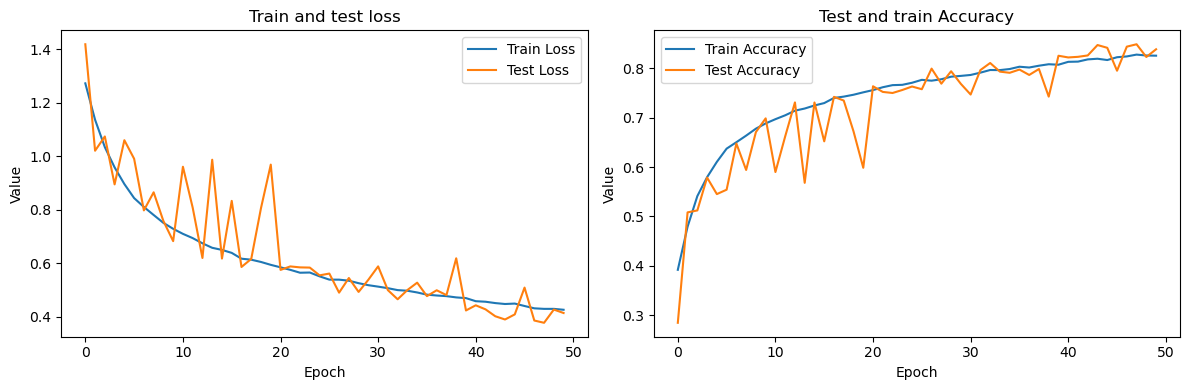

In [32]:
torch.manual_seed(42)
np.random.seed(42)

# Train and test model 
train_time_start_AlzheimerDet = timer()

# Initialize lists to store loss and accuracy values
train_losses = []
train_accuracies = []
test_losses = []
test_accuracies = []


epochs = 50
for epoch in tqdm(range(epochs)):
    print(f"Epoch: {epoch}\n---------")
    
    train_loss, train_acc =train_step(data_loader=train_loader, 
        model=AlzheimerDet, 
        loss_fn=loss_fn,
        optimizer=optimizer,
        accuracy_fn=accuracy_fn)
    train_losses.append(train_loss)
    train_accuracies.append(train_acc)
    
    
    test_loss, test_acc=test_step(data_loader=test_loader,
        model=AlzheimerDet,
        loss_fn=loss_fn,
        accuracy_fn=accuracy_fn)
    test_losses.append(test_loss)
    test_accuracies.append(test_acc)
    

    

train_time_end_AlzheimerDet = timer()
total_train_time_AlzheimerDet = print_train_time(start=train_time_start_AlzheimerDet,
                                           end=train_time_end_AlzheimerDet,
                                           device=device)

# final_learning_rate = scheduler.get_last_lr()[0]
# print(f"Final learning rate: {final_learning_rate:.6f}")

# Plotting graphs
epochs_range = range(epochs)

# Graph for accuracy
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, torch.tensor(train_losses).cpu().numpy(), label='Train Loss')
plt.plot(epochs_range, torch.tensor(test_losses).cpu().numpy(), label='Test Loss')

plt.xlabel('Epoch')
plt.ylabel('Value')
plt.title('Train and test loss')
plt.legend()

# Graph for loss
plt.subplot(1, 2, 2)
plt.plot(epochs_range, torch.tensor(train_accuracies).cpu().numpy(), label='Train Accuracy')
plt.plot(epochs_range, torch.tensor(test_accuracies).cpu().numpy(), label='Test Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Value')
plt.title('Test and train Accuracy')
plt.legend()

plt.tight_layout()
plt.show()



In [33]:
# GET alzheimerNET result

AlzheimerDet_results = eval_model(
    model=AlzheimerDet,
    data_loader=test_loader,
    loss_fn=loss_fn,
    accuracy_fn=accuracy_fn
)
AlzheimerDet_results

{'model_name': 'AlzheimerDetection',
 'model_loss': 0.41411471366882324,
 'model_acc': 0.83859375}

In [34]:
# import json

# alzheimerdet_training_results = {
#     'train_losses': train_losses,
#     'train_accuracies' : train_accuracies
#     'test_losses': test_losses,
#     'test_accuracies': test_accuracies
# }

# with open('alzheimerdet_training_results.json', 'w') as file:
#     json.dump(alzheimerdet_training_results, file)


In [35]:
# Save the model to a file
torch.save(AlzheimerDet.state_dict(), 'AlzheimerDetection_50.pth')

In [ ]:
# AlzheimerDet.load_state_dict(torch.load('AlzheimerDetection.pth'))
# AlzheimerDet.train(True)

In [36]:


# Define your model architecture

AlzheimerDet = AlzheimerDetection(input_shape=3,
                         hidden_units=64,
                         output_shape=len(class_names)).to(device)



In [ ]:
# Load the saved model state dictionary
AlzheimerDet.load_state_dict(torch.load('AlzheimerDetection_50.pth'))

<All keys matched successfully>

In [ ]:
# with open('alzheimerdet_training_results.json', 'r') as file:
#     results = json.load(file)

# train_losses = alzheimerdet_training_results['train_losses']
# train_accuracies = alzheimerdet_training_results['train_accuracies'
# test_losses = alzheimerdet_training_results['test_losses']
# test_accuracies = alzheimerdet_training_results['test_accuracies']


MAKING PREDICTIONS WITH ALZHEIMERNET

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


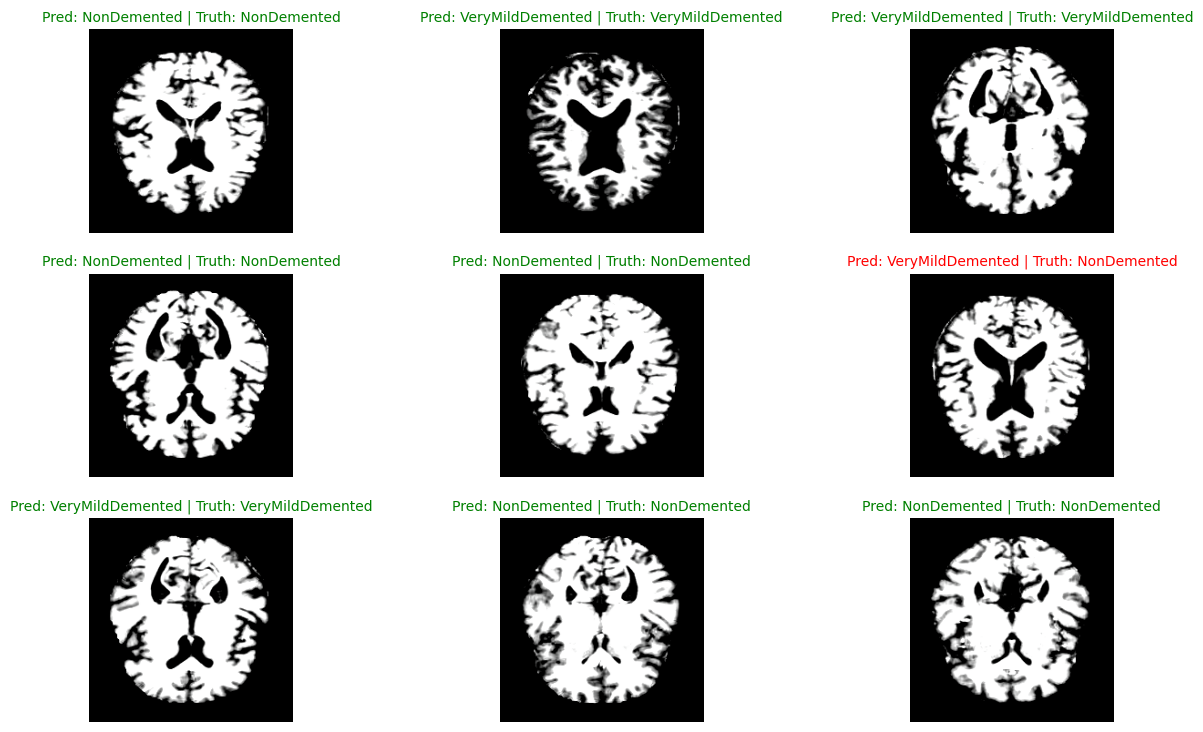

In [ ]:
torch.manual_seed(42)
np.random.seed(42)
import skimage.color as color

# Make predictions on test samples with alzheimerNET
pred_probs= make_predictions(model=AlzheimerDet, 
                             data=test_samples)

# View first two prediction probabilities list
pred_probs[:2]


# Turn the prediction probabilities into prediction labels by taking the argmax()
pred_classes = pred_probs.argmax(dim=1)
pred_classes


# Zip the test labels and predicted classes together
test_labels_pred = list(zip(test_labels, pred_classes))

# Randomly select 9 indices from the range of the number of test samples
random_indices = random.sample(range(len(test_samples)), 9)

# Plot predictions for the selected indices
plt.figure(figsize=(15, 9))
nrows = 3
ncols = 3
for i, index in enumerate(random_indices):
    sample = test_samples[index]
    
      # Convert grayscale image to RGB format
    rgb_image = color.gray2rgb(sample.permute(1, 2, 0))
    
    # Create a subplot
    plt.subplot(nrows, ncols, i + 1)

    # Plot the target image
    plt.imshow(sample.permute(1, 2, 0), cmap="gray")

    # Find the prediction label (in text form, e.g. "Sandal")
    pred_label = class_names[test_labels_pred[index][1]]

    # Get the truth label (in text form, e.g. "T-shirt")
    truth_label = class_names[test_labels_pred[index][0]]

    # Create the title text of the plot
    title_text = f"Pred: {pred_label} | Truth: {truth_label}"

    # Check for equality and change title color accordingly
    if pred_label == truth_label:
        plt.title(title_text, fontsize=10, c="g")  # green text if correct
    else:
        plt.title(title_text, fontsize=10, c="r")  # red text if wrong
    plt.axis(False)

## plotting confusion matrix fro ALZHEIMERNET

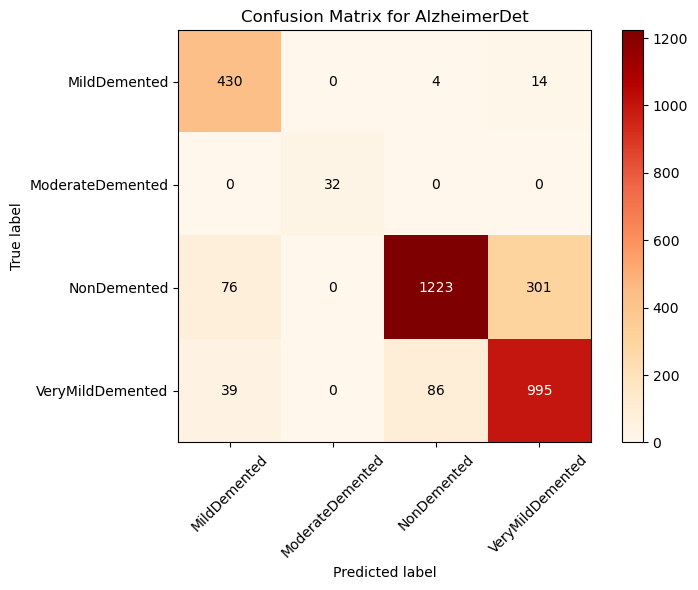

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix

# Assuming you have pred_classes and test_labels

class_names = ['MildDemented', 'ModerateDemented', 'NonDemented', 'VeryMildDemented'] 

# Compute the confusion matrix
alzheimerdet_cm = confusion_matrix(test_labels, pred_classes)

# Plot the confusion matrix
plt.figure(figsize=(8, 6))
plt.imshow(alzheimerdet_cm, cmap=plt.cm.OrRd)
plt.title('Confusion Matrix for AlzheimerDet')
plt.colorbar()
# class_names = ['MildDemented', 'ModerateDemented', 'NonDemented', 'VeryMildDemented']  # Replace with your actual class names
tick_marks = np.arange(len(class_names))
plt.xticks(tick_marks, class_names, rotation=45)
plt.yticks(tick_marks, class_names)

# Fill the confusion matrix cells with the counts
thresh = alzheimerdet_cm.max() / 2.
for i in range(alzheimerdet_cm.shape[0]):
    for j in range(alzheimerdet_cm.shape[1]):
        plt.text(j, i, format(alzheimerdet_cm[i, j], 'd'), ha="center", va="center",
                 color="white" if alzheimerdet_cm[i, j] > thresh else "black")

plt.xlabel('Predicted label')
plt.ylabel('True label')
plt.tight_layout()
plt.show()

## viewing  precision, recall, F1 score and support in a tabular form

In [ ]:
import numpy as np
import pandas as pd
from sklearn.metrics import precision_score, recall_score, f1_score, classification_report, confusion_matrix, matthews_corrcoef
from sklearn.metrics import jaccard_score, brier_score_loss

# Convert the `torch` tensors to `numpy` arrays.
pred_classes_np = torch.tensor(pred_classes).cpu().numpy()
test_labels_np = torch.tensor(test_labels).cpu().numpy()

# Calculate precision, recall, F1 score for each class
alzheimerdet_precision = precision_score(test_labels_np, pred_classes_np, average=None)
alzheimerdet_recall = recall_score(test_labels_np, pred_classes_np, average=None)
alzheimerdet_f1 = f1_score(test_labels_np, pred_classes_np, average=None)

# Calculate confusion matrix
alzheimerdet_cm = confusion_matrix(test_labels_np, pred_classes_np)

# Calculate sensitivity (recall) and specificity for each class
# sensitivity = recall
alzheimerdet_specificity = np.diagonal(alzheimerdet_cm) / (np.sum(alzheimerdet_cm, axis=1) - np.diagonal(alzheimerdet_cm))


# Calculate Matthews Correlation Coefficient
alzheimerdet_mcc = matthews_corrcoef(test_labels_np, pred_classes_np)

# Calculate Jaccard score (Intersection over Union)
alzheimerdet_jaccard = jaccard_score(test_labels_np, pred_classes_np, average=None)

# # Calculate Brier's score
# alzheimerdet_brier = brier_score_loss(test_labels_np, pred_classes_np)

# Count the number of samples per class
num_samples_per_class = np.bincount(test_labels_np)

# Create a DataFrame to store the results.
alzheimerdet_results = pd.DataFrame({
    'Class': class_names,
    'Precision': alzheimerdet_precision ,
    'Recall/Sensitivity': alzheimerdet_recall,
    'F1 Score': alzheimerdet_f1,
    'Specificity': alzheimerdet_specificity,
    'MCC': alzheimerdet_mcc,
    'Jaccard': alzheimerdet_jaccard,
     'Support': num_samples_per_class
    # 'Brier': alzheimerdet_brier
})

# Print the DataFrame
alzheimerdet_results


,Class,Precision,Recall/Sensitivity,F1 Score,Specificity,MCC,Jaccard,Support
0,MildDemented,0.788991,0.959821,0.866062,23.888889,0.748711,0.763766,448
1,ModerateDemented,1.000000,1.000000,1.000000,inf,0.748711,1.000000,32
2,NonDemented,0.931455,0.764375,0.839684,3.244032,0.748711,0.723669,1600
3,VeryMildDemented,0.759542,0.888393,0.818930,7.960000,0.748711,0.693380,1120


In [ ]:
from sklearn.metrics import roc_auc_score

# Calculate multiclass AUC
alzheimerdet_auc = roc_auc_score(test_labels_np, pred_probs, multi_class='ovr', average='macro')
print('Multiclass AUC:', alzheimerdet_auc)

Multiclass AUC: 0.9679976506846171


In [ ]:
import numpy as np
import pandas as pd
from sklearn.metrics import roc_curve, auc

num_classes = len(class_names)
# Convert the `torch` tensors to `numpy` arrays.
pred_probabilities_np = torch.tensor(pred_probs).cpu().numpy()  # Replace `pred_probabilities` with your model's predicted probabilities

# Calculate the false positive rate (fpr), true positive rate (tpr), and thresholds for each class
alzheimerdet_fprs = dict()
alzheimerdet_tprs = dict()
alzheimerdet_thresholds = dict()
for class_idx in range(num_classes):  # Replace `num_classes` with the number of classes in your problem
    alzheimerdet_fprs[class_idx], alzheimerdet_tprs[class_idx], alzheimerdet_thresholds[class_idx] = roc_curve(test_labels_np == class_idx, pred_probabilities_np[:, class_idx])

# Calculate the Area Under the ROC Curve (AUC) for each class
alzheimerdet_aucs = dict()
for class_idx in range(num_classes):  # Replace `num_classes` with the number of classes in your problem
    alzheimerdet_aucs[class_idx] = auc(alzheimerdet_fprs[class_idx], alzheimerdet_tprs[class_idx])



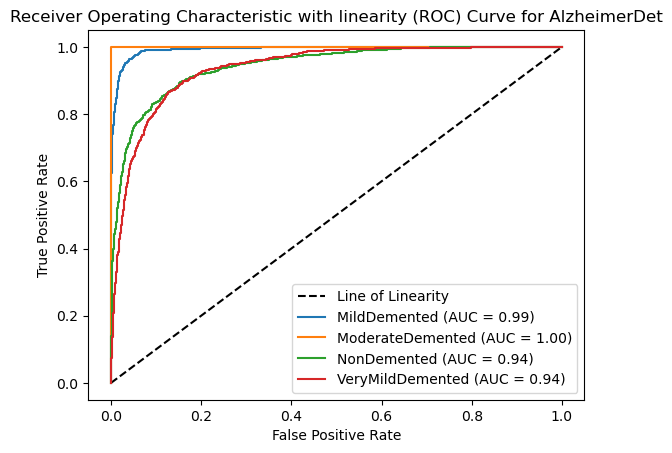

In [ ]:
import matplotlib.pyplot as plt


# Plot the ROC curve for each class
plt.figure()
plt.plot([0, 1], [0, 1], 'k--', label='Line of Linearity')
for class_idx in range(num_classes):  # Replace `num_classes` with the number of classes in your problem
    plt.plot(alzheimerdet_fprs[class_idx], alzheimerdet_tprs[class_idx], label=f'{class_names[class_idx]} (AUC = {alzheimerdet_aucs[class_idx]:.2f})')

    
# Set labels and title
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic with linearity (ROC) Curve for AlzheimerDet')

# Add a legend
plt.legend(loc='lower right')

# Show the plot
plt.show()

## DEFINING RESNET18 MODEL

In [45]:

import torchvision.models as models

class TransferResnetModel(nn.Module):
    def __init__(self, num_classes):
        super().__init__()
        self.resnet18 = models.resnet18(pretrained=True)
        num_features = self.resnet18.fc.in_features
        self.resnet18.fc = nn.Linear(num_features, 4)

    def forward(self, x):
        x = self.resnet18(x)
        return x

In [46]:
torch.manual_seed(42)
ResNet18 = TransferResnetModel(4).to(device)


# Setup loss function and optimizer
loss_fn = nn.CrossEntropyLoss() # this is also called "criterion"/"cost function" in some places
optimizer = torch.optim.Adam(params=ResNet18.parameters(), lr=0.001)

# Print the summary information
summary(ResNet18, input_size=(3, 224, 224))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 64, 112, 112]           9,408
       BatchNorm2d-2         [-1, 64, 112, 112]             128
              ReLU-3         [-1, 64, 112, 112]               0
         MaxPool2d-4           [-1, 64, 56, 56]               0
            Conv2d-5           [-1, 64, 56, 56]          36,864
       BatchNorm2d-6           [-1, 64, 56, 56]             128
              ReLU-7           [-1, 64, 56, 56]               0
            Conv2d-8           [-1, 64, 56, 56]          36,864
       BatchNorm2d-9           [-1, 64, 56, 56]             128
             ReLU-10           [-1, 64, 56, 56]               0
       BasicBlock-11           [-1, 64, 56, 56]               0
           Conv2d-12           [-1, 64, 56, 56]          36,864
      BatchNorm2d-13           [-1, 64, 56, 56]             128
             ReLU-14           [-1, 64,

In [47]:
import torch
import torchviz
from torchviz import make_dot


# Generate a random input tensor
input_tensor = torch.randn(32, 3, 224, 224).to(device)

# Pass the input through the model
output = ResNet18(input_tensor)

# Generate the DOT graph
dot = torchviz.make_dot(output, params=dict(ResNet18.named_parameters()))
dot.format = 'png'
dot.render(filename='ResNet18_graph2')

'ResNet18_graph2.png'

## TRAINING AND TESTING RESNET MODEL


  0%|          | 0/50 [00:00<?, ?it/s]

Epoch: 0
---------
Train loss: 0.805 | Train accuracy: 0.633
Test loss: 1.002 | Test accuracy: 0.511%

Epoch: 1
---------
Train loss: 1.566 | Train accuracy: 0.278
Test loss: 1.297 | Test accuracy: 0.500%

Epoch: 2
---------
Train loss: 1.338 | Train accuracy: 0.340
Test loss: 1.248 | Test accuracy: 0.443%

Epoch: 3
---------
Train loss: 1.234 | Train accuracy: 0.409
Test loss: 0.948 | Test accuracy: 0.513%

Epoch: 4
---------
Train loss: 1.040 | Train accuracy: 0.517
Test loss: 0.934 | Test accuracy: 0.513%

Epoch: 5
---------
Train loss: 0.871 | Train accuracy: 0.596
Test loss: 1.015 | Test accuracy: 0.488%

Epoch: 6
---------
Train loss: 0.773 | Train accuracy: 0.636
Test loss: 0.899 | Test accuracy: 0.555%

Epoch: 7
---------
Train loss: 0.715 | Train accuracy: 0.659
Test loss: 0.825 | Test accuracy: 0.564%

Epoch: 8
---------
Train loss: 0.672 | Train accuracy: 0.684
Test loss: 0.792 | Test accuracy: 0.604%

Epoch: 9
---------
Train loss: 0.639 | Train accuracy: 0.700
Test loss: 0

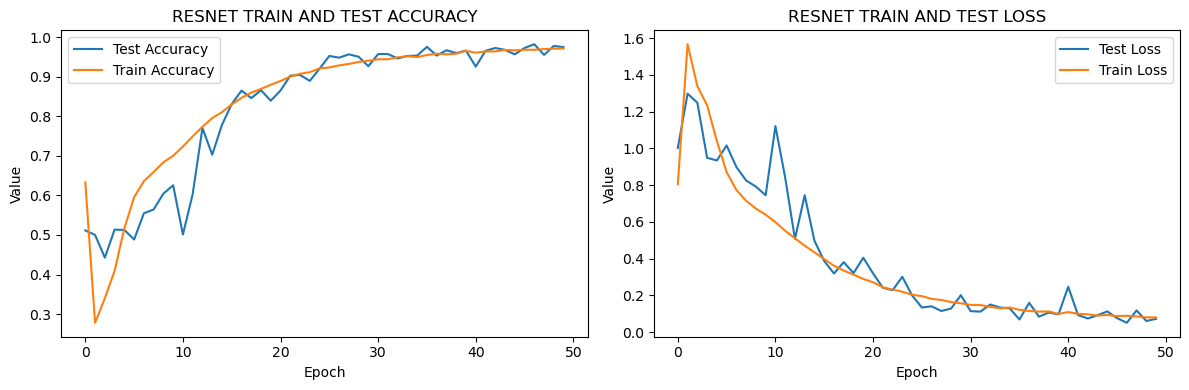

In [48]:
# Train and test model 
train_time_start_resnet = timer()

# Initialize lists to store loss and accuracy values
train_losses = []
train_accuracies = []
test_losses = []
test_accuracies = []

torch.manual_seed(42)
np.random.seed(42)

epochs = 50
for epoch in tqdm(range(epochs)):
    print(f"Epoch: {epoch}\n---------")
    train_loss, train_acc =train_step(data_loader=train_loader, 
        model=ResNet18, 
        loss_fn=loss_fn,
        optimizer=optimizer,
        accuracy_fn=accuracy_fn)
    train_losses.append(train_loss)
    train_accuracies.append(train_acc)
    
    
    test_loss, test_acc=test_step(data_loader=test_loader,
        model=ResNet18,
        loss_fn=loss_fn,
        accuracy_fn=accuracy_fn)
    test_losses.append(test_loss)
    test_accuracies.append(test_acc)
    
    
    
    

train_time_end_resnet = timer()
total_train_time_resnet = print_train_time(start=train_time_start_resnet,
                                           end=train_time_end_resnet,
                                           device=device)


# Plotting graphs
epochs_range = range(epochs)

# Graph for test loss and test accuracy
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, torch.tensor(test_accuracies).cpu().numpy(), label='Test Accuracy')
plt.plot(epochs_range, torch.tensor(train_accuracies).cpu().numpy(), label='Train Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Value')
plt.title('RESNET TRAIN AND TEST ACCURACY')
plt.legend()

# Graph for train loss and train accuracy
plt.subplot(1, 2, 2)
plt.plot(epochs_range, torch.tensor(test_losses).cpu().numpy(), label='Test Loss')
plt.plot(epochs_range, torch.tensor(train_losses).cpu().numpy(), label='Train Loss')

plt.xlabel('Epoch')
plt.ylabel('Value')
plt.title('RESNET TRAIN AND TEST LOSS')
plt.legend()

plt.tight_layout()
plt.show()

In [49]:
# Get RESNET results 
resnet_results = eval_model(
    model=ResNet18,
    data_loader=test_loader,
    loss_fn=loss_fn,
    accuracy_fn=accuracy_fn
)
resnet_results

{'model_name': 'TransferResnetModel',
 'model_loss': 0.07250048965215683,
 'model_acc': 0.97453125}

In [50]:
# Save the model to a file
torch.save(ResNet18.state_dict(), 'AlzheimerResNet_50.pth')

ResNet18 = TransferResnetModel(4).to(device)

# Load the saved model from file
ResNet18.load_state_dict(torch.load('AlzheimerResNet_50.pth'))

<All keys matched successfully>

## MAKING PREDICTION WITH RESNET MODEL

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


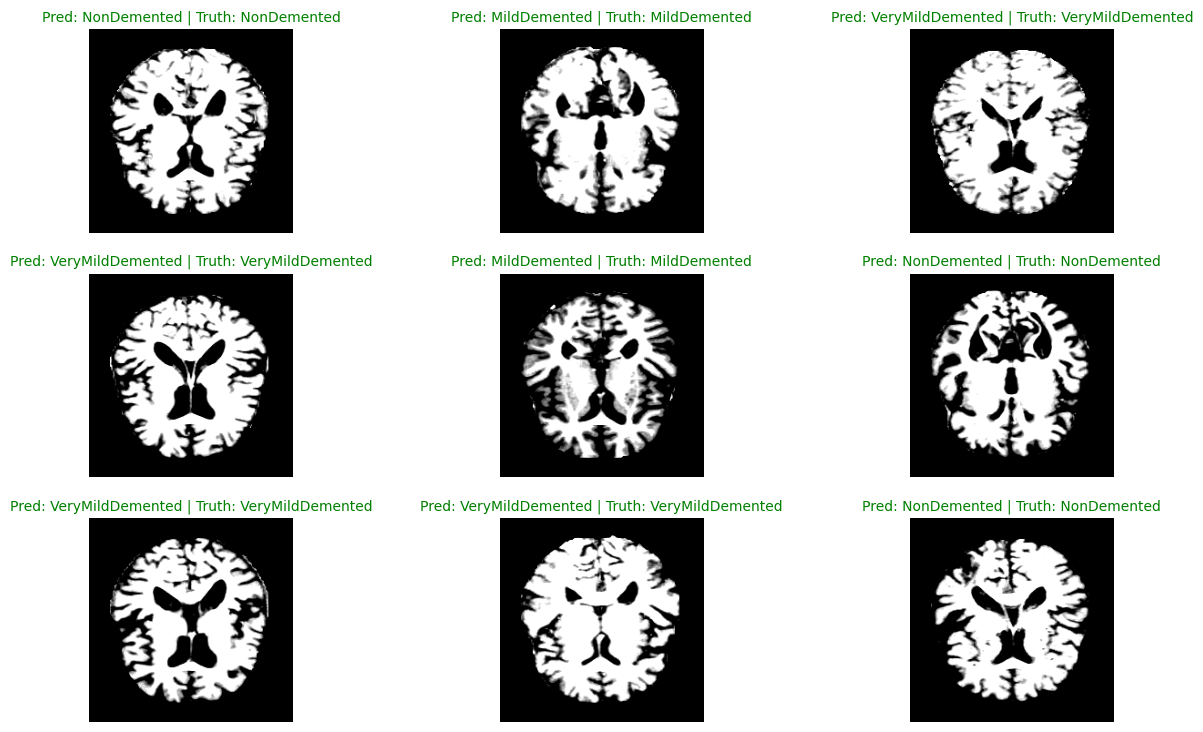

In [51]:
# Make predictions on test samples with RESNET
pred_probs= make_predictions(model=ResNet18, 
                             data=test_samples)

torch.manual_seed(42)
np.random.seed(42)


# View first two prediction probabilities list
pred_probs[:2]


# Turn the prediction probabilities into prediction labels by taking the argmax()
pred_classes = pred_probs.argmax(dim=1)
pred_classes


# Zip the test labels and predicted classes together
test_labels_pred = list(zip(test_labels, pred_classes))

# Randomly select 9 indices from the range of the number of test samples
random_indices = random.sample(range(len(test_samples)), 9)

# Plot predictions for the selected indices
plt.figure(figsize=(15, 9))
nrows = 3
ncols = 3
for i, index in enumerate(random_indices):
    sample = test_samples[index]
    # Create a subplot
    plt.subplot(nrows, ncols, i + 1)

    # Plot the target image
    plt.imshow(sample.permute(1, 2, 0), cmap="gray")

    # Find the prediction label (in text form, e.g. "Sandal")
    pred_label = class_names[test_labels_pred[index][1]]

    # Get the truth label (in text form, e.g. "T-shirt")
    truth_label = class_names[test_labels_pred[index][0]]

    # Create the title text of the plot
    title_text = f"Pred: {pred_label} | Truth: {truth_label}"

    # Check for equality and change title color accordingly
    if pred_label == truth_label:
        plt.title(title_text, fontsize=10, c="g")  # green text if correct
    else:
        plt.title(title_text, fontsize=10, c="r")  # red text if wrong
    plt.axis(False)

## PLOTTING CONFUSION MATRIX FOR RESNET

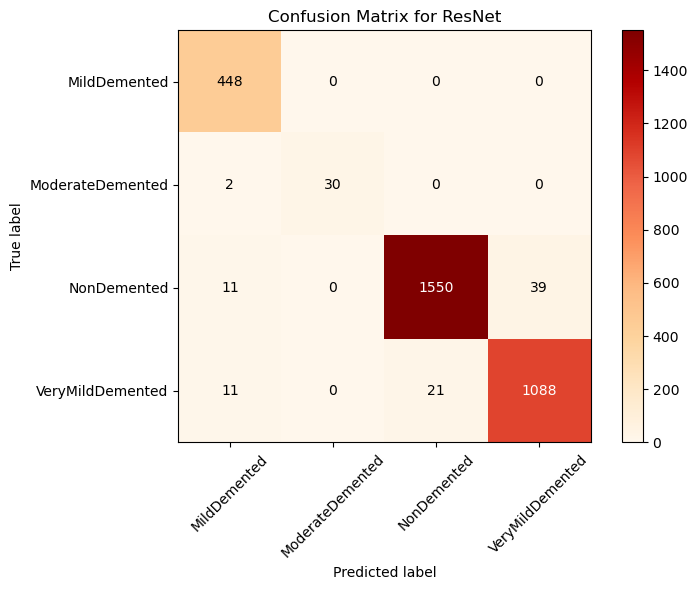

In [52]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix

# Assuming you have pred_classes and test_labels

class_names = ['MildDemented', 'ModerateDemented', 'NonDemented', 'VeryMildDemented'] 

# Compute the confusion matrix
resnet_cm = confusion_matrix(test_labels, pred_classes)

# Plot the confusion matrix
plt.figure(figsize=(8, 6))
plt.imshow(resnet_cm, cmap=plt.cm.OrRd)
plt.title('Confusion Matrix for ResNet')
plt.colorbar()
# class_names = ['MildDemented', 'ModerateDemented', 'NonDemented', 'VeryMildDemented']  # Replace with your actual class names
tick_marks = np.arange(len(class_names))
plt.xticks(tick_marks, class_names, rotation=45)
plt.yticks(tick_marks, class_names)

# Fill the confusion matrix cells with the counts
thresh = resnet_cm.max() / 2.
for i in range(resnet_cm.shape[0]):
    for j in range(resnet_cm.shape[1]):
        plt.text(j, i, format(resnet_cm[i, j], 'd'), ha="center", va="center",
                 color="white" if resnet_cm[i, j] > thresh else "black")

plt.xlabel('Predicted label')
plt.ylabel('True label')
plt.tight_layout()
plt.show()

In [53]:
import numpy as np
import pandas as pd
from sklearn.metrics import precision_score, recall_score, f1_score, classification_report, confusion_matrix, matthews_corrcoef
from sklearn.metrics import jaccard_score, brier_score_loss

# Convert the `torch` tensors to `numpy` arrays.
pred_classes_np = torch.tensor(pred_classes).cpu().numpy()
test_labels_np = torch.tensor(test_labels).cpu().numpy()

# Calculate precision, recall, F1 score for each class
resnet_precision = precision_score(test_labels_np, pred_classes_np, average=None)
resnet_recall = recall_score(test_labels_np, pred_classes_np, average=None)
resnet_f1 = f1_score(test_labels_np, pred_classes_np, average=None)

# Calculate confusion matrix
resnet_cm = confusion_matrix(test_labels_np, pred_classes_np)

# Calculate sensitivity (recall) and specificity for each class
# sensitivity = recall
resnet_specificity = np.diagonal(resnet_cm) / (np.sum(resnet_cm, axis=1) - np.diagonal(resnet_cm))


# Calculate Matthews Correlation Coefficient
resnet_mcc = matthews_corrcoef(test_labels_np, pred_classes_np)

# Calculate Jaccard score (Intersection over Union)
resnet_jaccard = jaccard_score(test_labels_np, pred_classes_np, average=None)

# # Calculate Brier's score
# alzheimerdet_brier = brier_score_loss(test_labels_np, pred_classes_np)

# Count the number of samples per class
num_samples_per_class = np.bincount(test_labels_np)

# Create a DataFrame to store the results.
resnet_metrics_results = pd.DataFrame({
    'Class': class_names,
    'Precision': resnet_precision ,
    'Recall/Sensitivity': resnet_recall,
    'F1 Score': resnet_f1,
    'Specificity': resnet_specificity,
    'MCC': resnet_mcc,
    'Jaccard': resnet_jaccard,
     'Support': num_samples_per_class
    # 'Brier': alzheimerdet_brier
})
resnet_metrics_results

,Class,Precision,Recall/Sensitivity,F1 Score,Specificity,MCC,Jaccard,Support
0,MildDemented,0.949153,1.000000,0.973913,inf,0.957126,0.949153,448
1,ModerateDemented,1.000000,0.937500,0.967742,15.0,0.957126,0.937500,32
2,NonDemented,0.986633,0.968750,0.977610,31.0,0.957126,0.956200,1600
3,VeryMildDemented,0.965395,0.971429,0.968402,34.0,0.957126,0.938740,1120


In [54]:
from sklearn.metrics import roc_auc_score

# Calculate multiclass AUC
resnet_auc = roc_auc_score(test_labels_np, pred_probs, multi_class='ovr', average='macro')
print('Multiclass AUC:', resnet_auc)

Multiclass AUC: 0.9988819547322227


In [55]:
import numpy as np
import pandas as pd
from sklearn.metrics import roc_curve, auc

num_classes = len(class_names)
# Convert the `torch` tensors to `numpy` arrays.
pred_probabilities_np = torch.tensor(pred_probs).cpu().numpy()  # Replace `pred_probabilities` with your model's predicted probabilities

# Calculate the false positive rate (fpr), true positive rate (tpr), and thresholds for each class
resnet_fprs = dict()
resnet_tprs = dict()
resnet_thresholds = dict()
for class_idx in range(num_classes):  # Replace `num_classes` with the number of classes in your problem
    resnet_fprs[class_idx], resnet_tprs[class_idx], resnet_thresholds[class_idx] = roc_curve(test_labels_np == class_idx, pred_probabilities_np[:, class_idx])

# Calculate the Area Under the ROC Curve (AUC) for each class
resnet_aucs = dict()
for class_idx in range(num_classes):  # Replace `num_classes` with the number of classes in your problem
    resnet_aucs[class_idx] = auc(resnet_fprs[class_idx], resnet_tprs[class_idx])



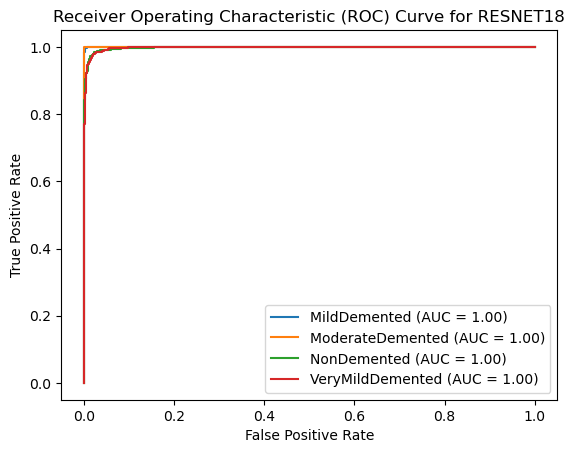

In [56]:
import matplotlib.pyplot as plt

# Plot the ROC curve for each class
for class_idx in range(num_classes):  # Replace `num_classes` with the number of classes in your problem
    plt.plot(resnet_fprs[class_idx], resnet_tprs[class_idx], label=f'{class_names[class_idx]} (AUC = {resnet_aucs[class_idx]:.2f})')

# Set labels and title
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve for RESNET18')

# Add a legend
plt.legend(loc='lower right')

# Show the plot
plt.show()

## DEFINING INCEPTION V3 MODEL

In [57]:


torch.manual_seed(42)
np.random.seed(42)

inception_v3 = models.inception_v3(pretrained=False, num_classes = 4, aux_logits = False,
                                   transform_input = False)

mod_inception_V3= inception_v3.to(device)


# Setup loss function and optimizer
loss_fn = nn.CrossEntropyLoss() # this is also called "criterion"/"cost function" in some places
optimizer = torch.optim.Adam(params=mod_inception_V3.parameters(), lr=0.001)

# Print the summary information
summary(mod_inception_V3, input_size=(3, 224, 224))


----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 32, 111, 111]             864
       BatchNorm2d-2         [-1, 32, 111, 111]              64
       BasicConv2d-3         [-1, 32, 111, 111]               0
            Conv2d-4         [-1, 32, 109, 109]           9,216
       BatchNorm2d-5         [-1, 32, 109, 109]              64
       BasicConv2d-6         [-1, 32, 109, 109]               0
            Conv2d-7         [-1, 64, 109, 109]          18,432
       BatchNorm2d-8         [-1, 64, 109, 109]             128
       BasicConv2d-9         [-1, 64, 109, 109]               0
        MaxPool2d-10           [-1, 64, 54, 54]               0
           Conv2d-11           [-1, 80, 54, 54]           5,120
      BatchNorm2d-12           [-1, 80, 54, 54]             160
      BasicConv2d-13           [-1, 80, 54, 54]               0
           Conv2d-14          [-1, 192,

## TRAINING INCEPTION V3 MODEL

  0%|          | 0/40 [00:00<?, ?it/s]

Epoch: 0
---------
Train loss: 1.372 | Train accuracy: 0.469
Test loss: 1.093 | Test accuracy: 0.482%

Epoch: 1
---------
Train loss: 1.257 | Train accuracy: 0.389
Test loss: 1.255 | Test accuracy: 0.376%

Epoch: 2
---------
Train loss: 0.967 | Train accuracy: 0.553
Test loss: 1.089 | Test accuracy: 0.434%

Epoch: 3
---------
Train loss: 0.813 | Train accuracy: 0.616
Test loss: 0.994 | Test accuracy: 0.492%

Epoch: 4
---------
Train loss: 0.750 | Train accuracy: 0.641
Test loss: 0.907 | Test accuracy: 0.525%

Epoch: 5
---------
Train loss: 0.704 | Train accuracy: 0.666
Test loss: 0.842 | Test accuracy: 0.564%

Epoch: 6
---------
Train loss: 0.669 | Train accuracy: 0.683
Test loss: 0.745 | Test accuracy: 0.634%

Epoch: 7
---------
Train loss: 0.632 | Train accuracy: 0.703
Test loss: 0.711 | Test accuracy: 0.642%

Epoch: 8
---------
Train loss: 0.586 | Train accuracy: 0.729
Test loss: 0.646 | Test accuracy: 0.693%

Epoch: 9
---------
Train loss: 0.543 | Train accuracy: 0.754
Test loss: 0

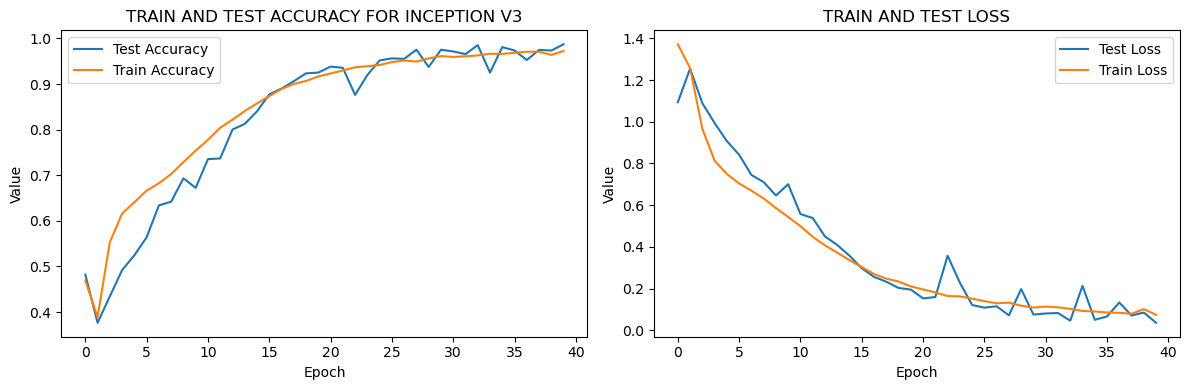

In [58]:
# Train and test INCEPTION
train_time_start_mod_inception = timer()

# Initialize lists to store loss and accuracy values
train_losses = []
train_accuracies = []
test_losses = []
test_accuracies = []


torch.manual_seed(42)
np.random.seed(42)


epochs = 40
for epoch in tqdm(range(epochs)):
    print(f"Epoch: {epoch}\n---------")
    train_loss, train_acc =train_step(data_loader=train_loader, 
        model=mod_inception_V3, 
        loss_fn=loss_fn,
        optimizer=optimizer,
        accuracy_fn=accuracy_fn)
    train_losses.append(train_loss)
    train_accuracies.append(train_acc)
    
    
    test_loss, test_acc=test_step(data_loader=test_loader,
        model=mod_inception_V3,
        loss_fn=loss_fn,
        accuracy_fn=accuracy_fn)
    test_losses.append(test_loss)
    test_accuracies.append(test_acc)
    
    
    
    

train_time_end_mod_inception = timer()
total_train_time_mod_inception = print_train_time(start=train_time_start_mod_inception,
                                           end=train_time_end_mod_inception,
                                           device=device)


# Plotting graphs
epochs_range = range(epochs)

# Graph for test loss and test accuracy
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, torch.tensor(test_accuracies).cpu().numpy(), label='Test Accuracy')
plt.plot(epochs_range, torch.tensor(train_accuracies).cpu().numpy(), label='Train Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Value')
plt.title('TRAIN AND TEST ACCURACY FOR INCEPTION V3')
plt.legend()

# Graph for train loss and train accuracy
plt.subplot(1, 2, 2)
plt.plot(epochs_range, torch.tensor(test_losses).cpu().numpy(), label='Test Loss')
plt.plot(epochs_range, torch.tensor(train_losses).cpu().numpy(), label='Train Loss')

plt.xlabel('Epoch')
plt.ylabel('Value')
plt.title('TRAIN AND TEST LOSS')
plt.legend()

plt.tight_layout()
plt.show()

In [59]:
# Get INCEPTION_V3 RESULT


mod_inception_results = eval_model(
    model=mod_inception_V3,
    data_loader=test_loader,
    loss_fn=loss_fn,
    accuracy_fn=accuracy_fn
)

mod_inception_results

{'model_name': 'Inception3',
 'model_loss': 0.035800814628601074,
 'model_acc': 0.98734375}

In [60]:
# Save the model to a file
torch.save(mod_inception_V3.state_dict(), 'ModifiedInceptionV3.pth')

# # Load the saved model from file
# mod_inception_V3.load_state_dict(torch.load('ModifiedInceptionV3.pth'))

In [62]:
# mod_inception_V3=inception_v3(pretrained=False, num_classes = 4, aux_logits = False,
#                                    transform_input = False).to(device)

mod_inception_V3= inception_v3.to(device)

In [63]:
# Load the saved model from file
mod_inception_V3.load_state_dict(torch.load('ModifiedInceptionV3.pth'))

<All keys matched successfully>

## MAKING PREDICTIONS WITH INCEPTION V3

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


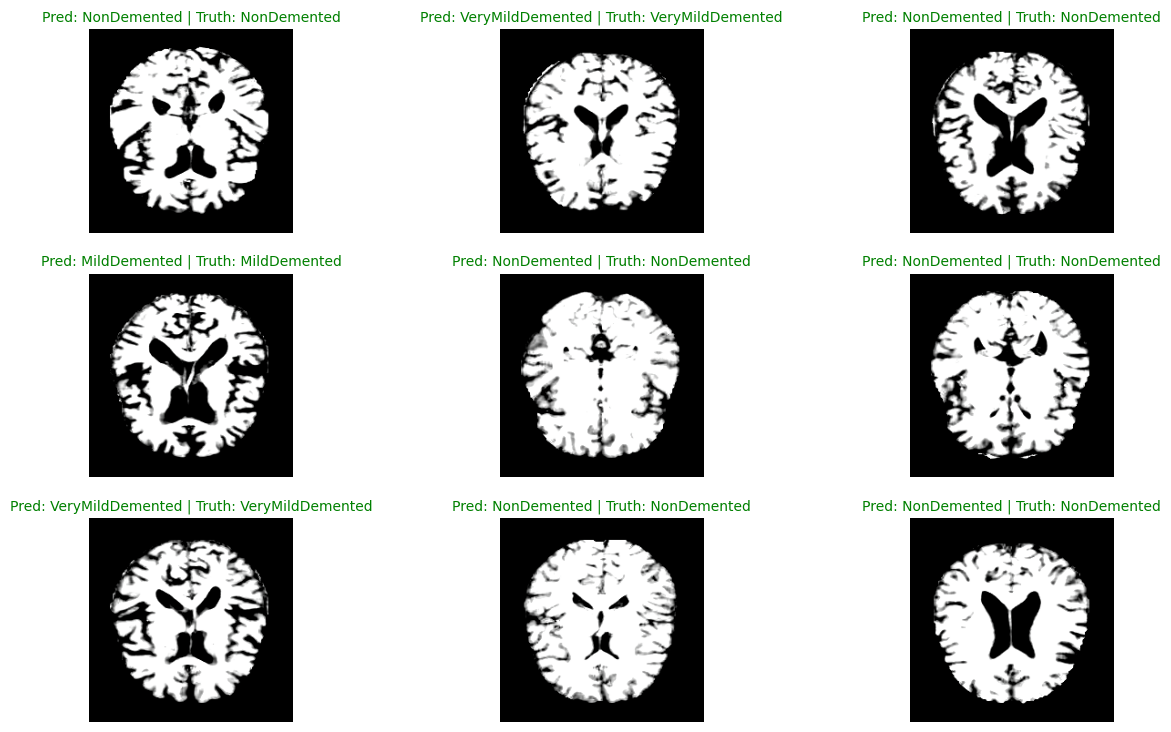

In [64]:
torch.manual_seed(42)
np.random.seed(42)


# Make predictions on test samples with INCEPTION
pred_probs= make_predictions(model=mod_inception_V3, 
                             data=test_samples)


# View first two prediction probabilities list
pred_probs[:2]


# Turn the prediction probabilities into prediction labels by taking the argmax()
pred_classes = pred_probs.argmax(dim=1)
pred_classes


# Zip the test labels and predicted classes together
test_labels_pred = list(zip(test_labels, pred_classes))

# Randomly select 9 indices from the range of the number of test samples
random_indices = random.sample(range(len(test_samples)), 9)

# Plot predictions for the selected indices
plt.figure(figsize=(15, 9))
nrows = 3
ncols = 3
for i, index in enumerate(random_indices):
    sample = test_samples[index]
    # Create a subplot
    plt.subplot(nrows, ncols, i + 1)

    # Plot the target image
    plt.imshow(sample.permute(1, 2, 0), cmap="gray")

    # Find the prediction label (in text form, e.g. "Sandal")
    pred_label = class_names[test_labels_pred[index][1]]

    # Get the truth label (in text form, e.g. "T-shirt")
    truth_label = class_names[test_labels_pred[index][0]]

    # Create the title text of the plot
    title_text = f"Pred: {pred_label} | Truth: {truth_label}"

    # Check for equality and change title color accordingly
    if pred_label == truth_label:
        plt.title(title_text, fontsize=10, c="g")  # green text if correct
    else:
        plt.title(title_text, fontsize=10, c="r")  # red text if wrong
    plt.axis(False)

## INCEPTION V3 CONFUSION MATRIX

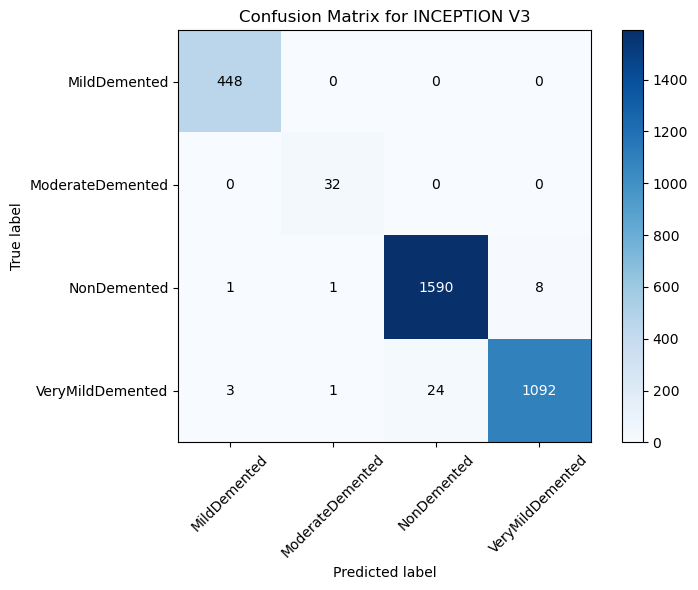

In [65]:
from sklearn.metrics import confusion_matrix

# Assuming you have pred_classes and test_labels

class_names = ['MildDemented', 'ModerateDemented', 'NonDemented', 'VeryMildDemented'] 

# Compute the confusion matrix
inception_cm = confusion_matrix(test_labels, pred_classes)

# Plot the confusion matrix
plt.figure(figsize=(8, 6))
plt.imshow(inception_cm, cmap=plt.cm.Blues)
plt.title('Confusion Matrix for INCEPTION V3')
plt.colorbar()
# class_names = ['MildDemented', 'ModerateDemented', 'NonDemented', 'VeryMildDemented']  # Replace with your actual class names
tick_marks = np.arange(len(class_names))
plt.xticks(tick_marks, class_names, rotation=45)
plt.yticks(tick_marks, class_names)

# Fill the confusion matrix cells with the counts
thresh = inception_cm.max() / 2.
for i in range(inception_cm.shape[0]):
    for j in range(inception_cm.shape[1]):
        plt.text(j, i, format(inception_cm[i, j], 'd'), ha="center", va="center",
                 color="white" if inception_cm[i, j] > thresh else "black")

plt.xlabel('Predicted label')
plt.ylabel('True label')
plt.tight_layout()
plt.show()


In [66]:
import numpy as np
import pandas as pd
from sklearn.metrics import precision_score, recall_score, f1_score, classification_report, confusion_matrix, matthews_corrcoef
from sklearn.metrics import jaccard_score, brier_score_loss

# Convert the `torch` tensors to `numpy` arrays.
pred_classes_np = torch.tensor(pred_classes).cpu().numpy()
test_labels_np = torch.tensor(test_labels).cpu().numpy()

# Calculate precision, recall, F1 score for each class
inception_precision = precision_score(test_labels_np, pred_classes_np, average=None)
inception_recall = recall_score(test_labels_np, pred_classes_np, average=None)
inception_f1 = f1_score(test_labels_np, pred_classes_np, average=None)

# Calculate confusion matrix
inception_cm = confusion_matrix(test_labels_np, pred_classes_np)

# Calculate sensitivity (recall) and specificity for each class
# sensitivity = recall
inception_specificity = np.diagonal(inception_cm) / (np.sum(inception_cm, axis=1) - np.diagonal(inception_cm))


# Calculate Matthews Correlation Coefficient
inception_mcc = matthews_corrcoef(test_labels_np, pred_classes_np)

# Calculate Jaccard score (Intersection over Union)
inception_jaccard = jaccard_score(test_labels_np, pred_classes_np, average=None)

# # Calculate Brier's score
# alzheimerdet_brier = brier_score_loss(test_labels_np, pred_classes_np)

# Count the number of samples per class
num_samples_per_class = np.bincount(test_labels_np)

# Create a DataFrame to store the results.
inception_results = pd.DataFrame({
    'Class': class_names,
    'Precision': inception_precision ,
    'Recall/Sensitivity': inception_recall,
    'F1 Score': inception_f1,
    'Specificity': inception_specificity,
    'MCC': inception_mcc,
    'Jaccard': inception_jaccard,
     'Support': num_samples_per_class
    # 'Brier': alzheimerdet_brier
})
inception_results

,Class,Precision,Recall/Sensitivity,F1 Score,Specificity,MCC,Jaccard,Support
0,MildDemented,0.991150,1.00000,0.995556,inf,0.980505,0.991150,448
1,ModerateDemented,0.941176,1.00000,0.969697,inf,0.980505,0.941176,32
2,NonDemented,0.985130,0.99375,0.989421,159.0,0.980505,0.979064,1600
3,VeryMildDemented,0.992727,0.97500,0.983784,39.0,0.980505,0.968085,1120


In [67]:
from sklearn.metrics import roc_auc_score

# Calculate multiclass AUC
inception_auc = roc_auc_score(test_labels_np, pred_probs, multi_class='ovr', average='macro')
print('Multiclass AUC:', auc)

Multiclass AUC: <function auc at 0x000001FDD8FC9C10>


In [68]:
import numpy as np
import pandas as pd
from sklearn.metrics import roc_curve, auc

num_classes = len(class_names)
# Convert the `torch` tensors to `numpy` arrays.
pred_probabilities_np = torch.tensor(pred_probs).cpu().numpy()  # Replace `pred_probabilities` with your model's predicted probabilities

# Calculate the false positive rate (fpr), true positive rate (tpr), and thresholds for each class
inception_fprs = dict()
inception_tprs = dict()
inception_thresholds = dict()
for class_idx in range(num_classes):  # Replace `num_classes` with the number of classes in your problem
    inception_fprs[class_idx], inception_tprs[class_idx], inception_thresholds[class_idx] = roc_curve(test_labels_np == class_idx, pred_probabilities_np[:, class_idx])

# Calculate the Area Under the ROC Curve (AUC) for each class
inception_aucs = dict()
for class_idx in range(num_classes):  # Replace `num_classes` with the number of classes in your problem
    inception_aucs[class_idx] = auc(inception_fprs[class_idx], inception_tprs[class_idx])

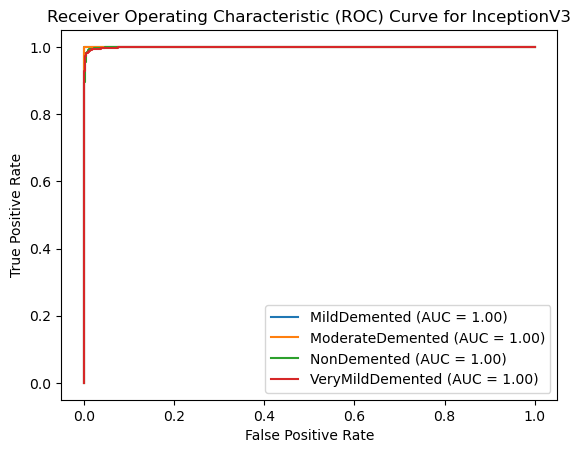

In [69]:
import matplotlib.pyplot as plt

# Plot the ROC curve for each class
for class_idx in range(num_classes):  # Replace `num_classes` with the number of classes in your problem
    plt.plot(inception_fprs[class_idx], inception_tprs[class_idx], label=f'{class_names[class_idx]} (AUC = {inception_aucs[class_idx]:.2f})')

# Set labels and title
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve for InceptionV3')

# Add a legend
plt.legend(loc='lower right')

# Show the plot
plt.show()

## COMPARE ALL RESULTS

In [70]:
import pandas as pd
compare_results = pd.DataFrame([AlzheimerDet_results, resnet_results, mod_inception_results])
compare_results

,model_name,model_loss,model_acc
0,AlzheimerDetection,0.414115,0.838594
1,TransferResnetModel,0.072500,0.974531
2,Inception3,0.035801,0.987344


In [71]:
# Add training times to results comparison
compare_results["training_time"] = [total_train_time_AlzheimerDet,
                                    total_train_time_resnet,
                                    total_train_time_mod_inception
                            ]
compare_results

,model_name,model_loss,model_acc,training_time
0,AlzheimerDetection,0.414115,0.838594,9157.907285
1,TransferResnetModel,0.072500,0.974531,5276.974977
2,Inception3,0.035801,0.987344,11027.060505


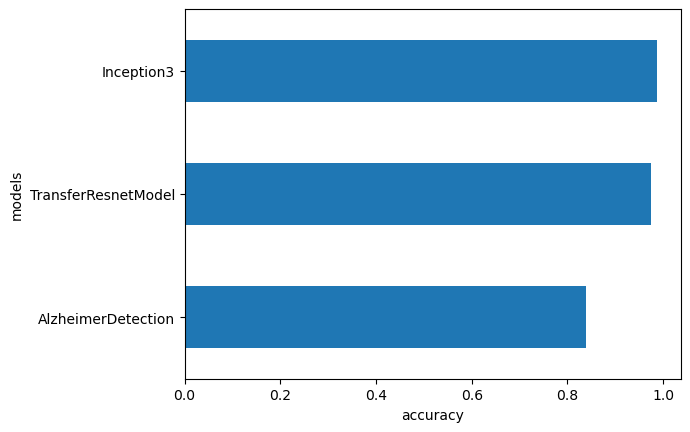

In [72]:
# Visualize our model results
compare_results.set_index("model_name")["model_acc"].plot(kind="barh")
plt.xlabel("accuracy")
plt.ylabel("models");

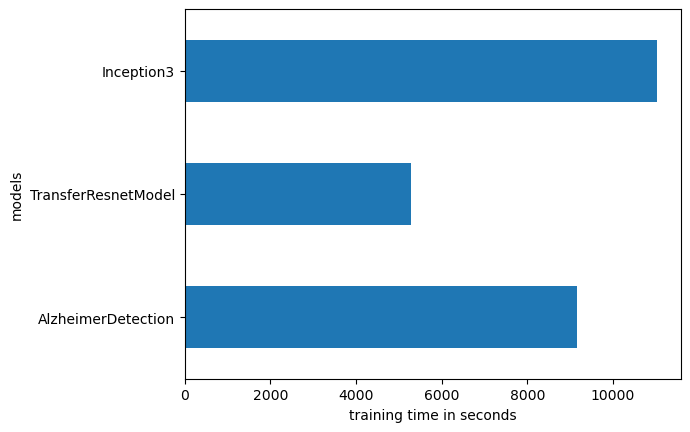

In [74]:
# Visualize our model results
compare_results.set_index("model_name")["training_time"].plot(kind="barh")
plt.xlabel("training time in seconds")
plt.ylabel("models");

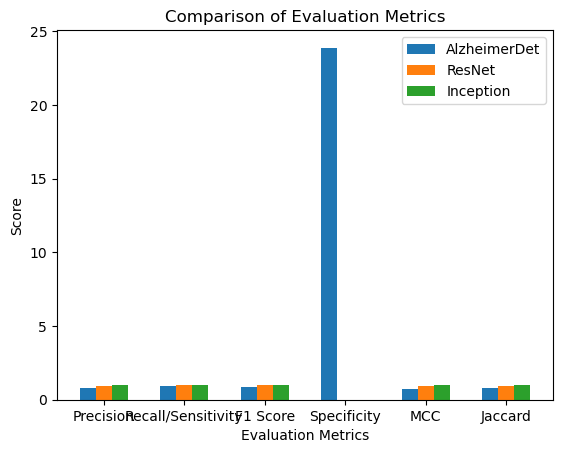

In [75]:
import matplotlib.pyplot as plt

# Create a list of the evaluation metric names
metrics = ['Precision', 'Recall/Sensitivity', 'F1 Score', 'Specificity', 'MCC', 'Jaccard']

# Get the evaluation metric values for each model
alzheimerdet_metrics = alzheimerdet_results[metrics].values[0]
resnet_metrics = resnet_metrics_results[metrics].values[0]
inception_metrics = inception_results[metrics].values[0]

# Set the positions of the bars on the x-axis
x = range(len(metrics))

# Set the width of the bars
bar_width = 0.2

# Plot the bars for each model's evaluation metrics
plt.bar(x, alzheimerdet_metrics, width=bar_width, label='AlzheimerDet')
plt.bar([val + bar_width for val in x], resnet_metrics, width=bar_width, label='ResNet')
plt.bar([val + 2 * bar_width for val in x], inception_metrics, width=bar_width, label='Inception')

# Set the x-axis labels
plt.xlabel('Evaluation Metrics')
plt.ylabel('Score')

# Set the title of the bar chart
plt.title('Comparison of Evaluation Metrics')

# Set the position of the x-axis ticks and labels
plt.xticks([val + bar_width for val in x], metrics)

# Display the legend
plt.legend()

# Show the plot
plt.show()


## TRYING ATTENTION NET

In [ ]:
class SelfAttention(nn.Module):
    def __init__(self, in_channels):
        super(SelfAttention, self).__init__()

        self.query_conv = nn.Conv2d(in_channels, in_channels // 8, kernel_size=1)
        self.key_conv = nn.Conv2d(in_channels, in_channels // 8, kernel_size=1)
        self.value_conv = nn.Conv2d(in_channels, in_channels, kernel_size=1)
        self.gamma = nn.Parameter(torch.zeros(1))

    def forward(self, x):
        batch_size, channels, height, width = x.size()

        query = self.query_conv(x).view(batch_size, -1, height * width).permute(0, 2, 1)
        key = self.key_conv(x).view(batch_size, -1, height * width)
        energy = torch.bmm(query, key)
        attention = F.softmax(energy, dim=-1)

        value = self.value_conv(x).view(batch_size, -1, height * width).permute(0, 2, 1)
        attended_x = torch.bmm(attention.permute(0, 2, 1), value)
        attended_x = attended_x.view(batch_size, channels, height, width)

        out = self.gamma * attended_x + x
        return out


class AttentionAlzheimerDetection(nn.Module):
    def __init__(self, input_shape: int, hidden_units: int, output_shape: int):
        super().__init__()

        # LAYER ONE
        self.conv_block_1 = nn.Sequential(
            nn.Conv2d(in_channels=input_shape,
                      out_channels=hidden_units,
                      kernel_size=3,
                      stride=1,
                      padding=1),
            nn.ReLU(),
            nn.Dropout(0.25),

            nn.Conv2d(in_channels=hidden_units,
                      out_channels=hidden_units,
                      kernel_size=3,
                      stride=1,
                      padding=1),
            nn.ReLU(),
            nn.Dropout(0.25),
            nn.MaxPool2d(kernel_size=2, stride=2)
        )

        # LAYER TWO
        self.conv_block_2 = nn.Sequential(
            nn.Conv2d(in_channels=hidden_units,
                      out_channels=hidden_units,
                      kernel_size=3,
                      stride=1,
                      padding=1),
            nn.ReLU(),
            nn.Dropout(0.25),

            nn.Conv2d(in_channels=hidden_units,
                      out_channels=hidden_units,
                      kernel_size=3,
                      stride=1,
                      padding=1),
            nn.ReLU(),
            nn.Dropout(0.25),
            nn.MaxPool2d(kernel_size=2, stride=2)
        )

        # Attention mechanism
        self.attention_block_1 = SelfAttention(hidden_units)
        self.attention_block_2 = SelfAttention(hidden_units)

        # CLASSIFIER LAYER
        self.classifier = nn.Sequential(
            nn.Flatten(),
            nn.Linear(in_features=hidden_units * 56 * 56,
                      out_features=output_shape)
        )

    def forward(self, x):
        x = self.conv_block_1(x)
        x = self.attention_block_1(x)
        x = self.conv_block_2(x)
        x = self.attention_block_2(x)

        x = self.classifier(x)
        return x

In [ ]:
torch.manual_seed(42)
np.random.seed(42)


Attn_AlzheimerDet = AttentionAlzheimerDetection(input_shape=3,
                         hidden_units=64,
                         output_shape=len(class_names)).to(device)


# Setup loss function and optimizer
loss_fn = nn.CrossEntropyLoss() # this is also called "criterion"/"cost function" in some places
optimizer = torch.optim.SGD(params=Attn_AlzheimerDet.parameters(), lr=0.001, momentum = 0.9)
# scheduler = StepLR(optimizer, step_size=5, gamma=0.1)

# Print the summary information
summary(Attn_AlzheimerDet, input_size=(3, 224, 224))

In [ ]:
# Create a DataLoader with the  TRAIN dataset and the TEST data
size_of_workers= 2
size_of_batch = 1
attention_train_loader = DataLoader(train_folder_new, batch_size=size_of_batch, shuffle=True,  num_workers=size_of_workers)
attention_test_loader = DataLoader(test_folder_new, batch_size=size_of_batch,shuffle=False,  num_workers=size_of_workers)

In [ ]:


import torch
import torchviz
from torchviz import make_dot
# Generate a random input tensor
input_tensor = torch.randn(2, 3, 224, 224).to(device)

# Pass the input through the model
output = Attn_AlzheimerDet(input_tensor)

# Generate the DOT graph
dot = torchviz.make_dot(output, params=dict(Attn_AlzheimerDet.named_parameters()))
dot.format = 'png'
dot.render(filename='Attention_AlzheimerDetection')

# TRAINING ATTENTION ALZHEIMER DETECTION MODEL

In [ ]:


# with torch.cuda.device(device):
#     info = torch.cuda.mem_get_info()
#     return info


def mem_get_info(device):
    with torch.cuda.device(device=device):
        return torch.cuda.mem_get_info()

mem_get_info(device)

In [ ]:
torch.manual_seed(42)
np.random.seed(42)

# Train and test model 
train_time_start_Attn_AlzheimerDet = timer()

# Initialize lists to store loss and accuracy values
train_losses = []
train_accuracies = []
test_losses = []
test_accuracies = []


epochs = 50
for epoch in tqdm(range(epochs)):
    print(f"Epoch: {epoch}\n---------")
    
    train_loss, train_acc =train_step(data_loader=attention_train_loader, 
        model=Attn_AlzheimerDet, 
        loss_fn=loss_fn,
        optimizer=optimizer,
        accuracy_fn=accuracy_fn)
    train_losses.append(train_loss)
    train_accuracies.append(train_acc)
    
    
    test_loss, test_acc=test_step(data_loader=attention_test_loader,
        model=Attn_AlzheimerDet,
        loss_fn=loss_fn,
        accuracy_fn=accuracy_fn)
    test_losses.append(test_loss)
    test_accuracies.append(test_acc)
    

    

train_time_end_Attn_AlzheimerDet = timer()
total_train_time_Attn_AlzheimerDet = print_train_time(start=train_time_start_Attn_AlzheimerDet,
                                           end=train_time_end_Attn_AlzheimerDet,
                                           device=device)

# final_learning_rate = scheduler.get_last_lr()[0]
# print(f"Final learning rate: {final_learning_rate:.6f}")

# Plotting graphs
epochs_range = range(epochs)

# Graph for accuracy
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, torch.tensor(train_losses).cpu().numpy(), label='Train Loss')
plt.plot(epochs_range, torch.tensor(test_losses).cpu().numpy(), label='Test Loss')

plt.xlabel('Epoch')
plt.ylabel('Value')
plt.title('Train and test loss for Attn_AlzheimerDet')
plt.legend()

# Graph for loss
plt.subplot(1, 2, 2)
plt.plot(epochs_range, torch.tensor(train_accuracies).cpu().numpy(), label='Train Accuracy')
plt.plot(epochs_range, torch.tensor(test_accuracies).cpu().numpy(), label='Test Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Value')
plt.title('Test and train Accuracy for Attn_AlzheimerDet')
plt.legend()

plt.tight_layout()
plt.show()

In [ ]:
# GET alzheimerNET result

 Attention_AlzheimerDet_results = eval_model(
    model= Attn_AlzheimerDet,
    data_loader=test_loader,
    loss_fn=loss_fn,
    accuracy_fn=accuracy_fn
)
Attention_AlzheimerDet_results

In [ ]:
# Save the model to a file
torch.save Attn_AlzheimerDet.state_dict(), 'AttentionAlzheimerDetection.pth')

In [ ]:
# Define your model architecture

 Attn_AlzheimerDet = AttentionAlzheimerDetection(input_shape=3,
                         hidden_units=64,
                         output_shape=len(class_names)).to(device)



In [ ]:
# Load the saved model state dictionary
 Attn_AlzheimerDet.load_state_dict(torch.load('AttentionAlzheimerDetection.pth'))

# MAKING PREDICTION WITH ATTENTION ALZHEIMER DETECTION MODEL

In [ ]:
torch.manual_seed(42)
np.random.seed(42)
import skimage.color as color

# Make predictions on test samples with alzheimerNET
pred_probs= make_predictions(model= Attn_AlzheimerDet, 
                             data=test_samples)

# View first two prediction probabilities list
pred_probs[:2]


# Turn the prediction probabilities into prediction labels by taking the argmax()
pred_classes = pred_probs.argmax(dim=1)
pred_classes


# Zip the test labels and predicted classes together
test_labels_pred = list(zip(test_labels, pred_classes))

# Randomly select 9 indices from the range of the number of test samples
random_indices = random.sample(range(len(test_samples)), 9)

# Plot predictions for the selected indices
plt.figure(figsize=(15, 9))
nrows = 3
ncols = 3
for i, index in enumerate(random_indices):
    sample = test_samples[index]
    
      # Convert grayscale image to RGB format
    rgb_image = color.gray2rgb(sample.permute(1, 2, 0))
    
    # Create a subplot
    plt.subplot(nrows, ncols, i + 1)

    # Plot the target image
    plt.imshow(sample.permute(1, 2, 0), cmap="gray")

    # Find the prediction label (in text form, e.g. "Sandal")
    pred_label = class_names[test_labels_pred[index][1]]

    # Get the truth label (in text form, e.g. "T-shirt")
    truth_label = class_names[test_labels_pred[index][0]]

    # Create the title text of the plot
    title_text = f"Pred: {pred_label} | Truth: {truth_label}"

    # Check for equality and change title color accordingly
    if pred_label == truth_label:
        plt.title(title_text, fontsize=10, c="g")  # green text if correct
    else:
        plt.title(title_text, fontsize=10, c="r")  # red text if wrong
    plt.axis(False)

# PLOTTING CONFUSION METRICS FOR ATTENTION ALZHEIMER DETECTION MODEL

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix

# Assuming you have pred_classes and test_labels

class_names = ['MildDemented', 'ModerateDemented', 'NonDemented', 'VeryMildDemented'] 

# Compute the confusion matrix
Attn_AlzheimerDet_cm = confusion_matrix(test_labels, pred_classes)

# Plot the confusion matrix
plt.figure(figsize=(8, 6))
plt.imshow(Attn_AlzheimerDet_cm, cmap=plt.cm.OrRd)
plt.title('Confusion Matrix for AttentionAlzheimerDetection')
plt.colorbar()
# class_names = ['MildDemented', 'ModerateDemented', 'NonDemented', 'VeryMildDemented']  # Replace with your actual class names
tick_marks = np.arange(len(class_names))
plt.xticks(tick_marks, class_names, rotation=45)
plt.yticks(tick_marks, class_names)

# Fill the confusion matrix cells with the counts
thresh = Attn_AlzheimerDet_cm.max() / 2.
for i in range(Attn_AlzheimerDet_cm.shape[0]):
    for j in range(Attn_AlzheimerDet_cm.shape[1]):
        plt.text(j, i, format(Attn_AlzheimerDet_cm[i, j], 'd'), ha="center", va="center",
                 color="white" if Attn_AlzheimerDet_cm[i, j] > thresh else "black")

plt.xlabel('Predicted label')
plt.ylabel('True label')
plt.tight_layout()
plt.show()

In [ ]:
from sklearn.metrics import precision_score, recall_score, f1_score, classification_report, confusion_matrix, matthews_corrcoef
from sklearn.metrics import jaccard_score, brier_score_loss

# Convert the `torch` tensors to `numpy` arrays.
pred_classes_np = torch.tensor(pred_classes).cpu().numpy()
test_labels_np = torch.tensor(test_labels).cpu().numpy()

# Calculate precision, recall, F1 score for each class
Attn_AlzheimerDet_precision = precision_score(test_labels_np, pred_classes_np, average=None)
Attn_AlzheimerDet_recall = recall_score(test_labels_np, pred_classes_np, average=None)
Attn_AlzheimerDet_f1 = f1_score(test_labels_np, pred_classes_np, average=None)

# Calculate confusion matrix
Attn_AlzheimerDet_cm = confusion_matrix(test_labels_np, pred_classes_np)

# Calculate sensitivity (recall) and specificity for each class
# sensitivity = recall
Attn_AlzheimerDet_specificity = np.diagonal(Attn_AlzheimerDet_cm) / (np.sum(Attn_AlzheimerDet_cm, axis=1) - np.diagonal(Attn_AlzheimerDet_cm))


# Calculate Matthews Correlation Coefficient
Attn_AlzheimerDet_mcc = matthews_corrcoef(test_labels_np, pred_classes_np)

# Calculate Jaccard score (Intersection over Union)
Attn_AlzheimerDet_jaccard = jaccard_score(test_labels_np, pred_classes_np, average=None)

# # Calculate Brier's score
# alzheimerdet_brier = brier_score_loss(test_labels_np, pred_classes_np)

# Count the number of samples per class
num_samples_per_class = np.bincount(test_labels_np)

# Create a DataFrame to store the results.
Attn_AlzheimerDet_results = pd.DataFrame({
    'Class': class_names,
    'Precision': Attn_AlzheimerDet_precision ,
    'Recall/Sensitivity': Attn_AlzheimerDet_recall,
    'F1 Score': Attn_AlzheimerDet_f1,
    'Specificity': Attn_AlzheimerDet_specificity,
    'MCC': Attn_AlzheimerDet_mcc,
    'Jaccard': Attn_AlzheimerDet_jaccard,
     'Support': num_samples_per_class
    # 'Brier': alzheimerdet_brier
})

# Print the DataFrame
print(Attn_AlzheimerDet_results)

In [ ]:
from sklearn.metrics import roc_auc_score

# Calculate multiclass AUC
Attn_AlzheimerDet_auc = roc_auc_score(test_labels_np, pred_probs, multi_class='ovr', average='macro')
print('Multiclass AUC:', Attn_AlzheimerDet_auc)

In [ ]:
import numpy as np
import pandas as pd
from sklearn.metrics import roc_curve, auc

num_classes = len(class_names)
# Convert the `torch` tensors to `numpy` arrays.
pred_probabilities_np = torch.tensor(pred_probs).cpu().numpy()  # Replace `pred_probabilities` with your model's predicted probabilities

# Calculate the false positive rate (fpr), true positive rate (tpr), and thresholds for each class
Attn_AlzheimerDet_fprs = dict()
Attn_AlzheimerDet_tprs = dict()
Attn_AlzheimerDet_thresholds = dict()
for class_idx in range(num_classes):  # Replace `num_classes` with the number of classes in your problem
    Attn_AlzheimerDet_fprs[class_idx], Attn_AlzheimerDet_tprs[class_idx], Attn_AlzheimerDet_thresholds[class_idx] = roc_curve(test_labels_np == class_idx, pred_probabilities_np[:, class_idx])

# Calculate the Area Under the ROC Curve (AUC) for each class
Attn_AlzheimerDet_aucs = dict()
for class_idx in range(num_classes):  # Replace `num_classes` with the number of classes in your problem
    Attn_AlzheimerDet_aucs[class_idx] = auc(Attn_AlzheimerDet_fprs[class_idx], Attn_AlzheimerDet_tprs[class_idx])


In [ ]:
import matplotlib.pyplot as plt

# Plot the ROC curve for each class
for class_idx in range(num_classes):  # Replace `num_classes` with the number of classes in your problem
    plt.plot(Attn_AlzheimerDet_fprs[class_idx], Attn_AlzheimerDet_tprs[class_idx], label=f'{class_names[class_idx]} (AUC = {Attn_AlzheimerDet_aucs[class_idx]:.2f})')

# Set labels and title
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve for AttentionAlzheimerDetection')

# Add a legend
plt.legend(loc='lower right')

# Show the plot
plt.show()